In [100]:
import os
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
# os.getcwd()
file_path = os.path.join(os.pardir, 'data', 'used_car_prices', 'Used_Car_Dataset.csv')
# os.listdir(file_path)

Quick read on understanding Horsepower and Torque
https://www.wkcdjrsedalia.com/research/basics-horsepower-torque.htm

In [245]:
#Read in data
df = pd.read_csv(file_path)

# Drop the first column
df = df.iloc[:,1:]

## engine(cc) and maxpoer(bhp) are exactly the same
###verify
# (df['engine(cc)']!=df['max_power(bhp)']).sum()
df = df.drop('engine(cc)', axis=1)

# Drop missing values
df = df.dropna(how='any')

df.columns = ['car_name', 'registration_year', 'insurance_validity', 'fuel_type',
       'seats', 'kms_driven', 'ownership', 'transmission',
       'manufacturing_year', 'mileage_kmpl', 'max_power_bhp', 'torque_Nm',
       'price_lakhs']

# remove rows with garbage values in ownership column
df = df[df.ownership.str.contains('Owner')]

## Price, mileage, power and torque all of which have outliers
## Will remove records with values above 99th percentile
kms_driven_99 = np.quantile(df['kms_driven'], 0.99)
# mileage_kmpl_95 = np.quantile(df['mileage_kmpl'], 0.95)
## mileage has some data issues with certain cars. Mileage cannot be > 30. So for now we will drop mileage above 50 mpl
max_power_bhp_99 = np.quantile(df['max_power_bhp'], 0.99)
torque_Nm_99 = np.quantile(df['torque_Nm'], 0.99)
price_99 = np.quantile(df['price_lakhs'], 0.99)

df = df[df['kms_driven'] <= kms_driven_99]
# df = df[df['mileage_kmpl'] <= mileage_kmpl_95]
df = df[df['mileage_kmpl'] <= 30]
df = df[df['max_power_bhp'] <= max_power_bhp_99]
df = df[df['torque_Nm'] <= torque_Nm_99]
df = df[df['price_lakhs'] <= price_99]

# Convert registration_year to date
df['registration_year_6'] = pd.to_datetime(df.registration_year, format='%b-%y', errors='coerce')
df['registration_year_4'] = pd.to_datetime(df.registration_year, format='%Y', errors='coerce')
df['registration_year'] = df['registration_year_6'].combine_first(df['registration_year_4'])
df = df.drop(['registration_year_6', 'registration_year_4'], axis=1)

# Convert manufacturing_year to date
df['manufacturing_year'] = pd.to_datetime(df.manufacturing_year, format='%Y', errors='coerce')

# extracting Car manufacturer name (partial)
df['manuf'] = df.car_name.map(lambda x: x.strip().split()[1])

# computing num months used. For ownership==First Owner, we use date of registration, else year of manufacture
latest_dt = df.registration_year.max()
df['mnths_used'] =  np.where(df.ownership == 'First Owner', latest_dt-df.registration_year, latest_dt-df.manufacturing_year)
df['mnths_used'] = df['mnths_used'].dt.days
df['mnths_manf'] = latest_dt - df.manufacturing_year
df['mnths_manf'] = df['mnths_manf'].dt.days

# Select categorical and quantitative variables only
df = df.iloc[:,np.r_[2:8, 9:15]]

# splitting the data set into testing and training datasets
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

# Splitting apart the dependent and independent variables
# df_X_train = df_train.iloc[:,df_train.columns!='price_lakhs']
df_X_train = df_train.drop('price_lakhs', axis=1)
df_y_train = df_train['price_lakhs']

# Separating out the numeric and categorical variables in the dataframe
df_num = df_X_train.select_dtypes(include=[np.number])
df_cat = df_X_train.select_dtypes(include=[object])

In [246]:
## Creating pipelines for transforming the dataset

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

num_pipeline = Pipeline([('std_scaler', StandardScaler())
                        ,])
cat_pipeline = Pipeline([('1hot_encoder', OneHotEncoder())
                        ,])

full_pipeline = ColumnTransformer([
    ('num_pipeline', num_pipeline, list(df_num.columns))
    , ('cat_pipeline', cat_pipeline, list(df_cat.columns))
])

In [247]:
df_X_train_prepared = full_pipeline.fit_transform(df_X_train)

In [248]:
# try training a linesr regression model

from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(df_X_train_prepared, df_y_train)

LinearRegression()

In [249]:
# predict values from trained model

y_preds = lin_reg.predict(df_X_train_prepared)

In [250]:
# use performance metrics to measure model performance

from sklearn.metrics import mean_squared_error

lin_reg_mse = mean_squared_error(df_y_train, y_preds)
np.sqrt(lin_reg_mse)

8.421867383186417

In [252]:
df_X_train_prepared

<1025x47 sparse matrix of type '<class 'numpy.float64'>'
	with 11275 stored elements in Compressed Sparse Row format>

In [230]:
df.info()
df.head()
df.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1282 entries, 0 to 1552
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   car_name            1282 non-null   object        
 1   registration_year   1282 non-null   datetime64[ns]
 2   insurance_validity  1282 non-null   object        
 3   fuel_type           1282 non-null   object        
 4   seats               1282 non-null   int64         
 5   kms_driven          1282 non-null   int64         
 6   ownership           1282 non-null   object        
 7   transmission        1282 non-null   object        
 8   manufacturing_year  1282 non-null   datetime64[ns]
 9   mileage_kmpl        1282 non-null   float64       
 10  max_power_bhp       1282 non-null   float64       
 11  torque_Nm           1282 non-null   float64       
 12  price_lakhs         1282 non-null   float64       
 13  manuf               1282 non-null   object      

,seats,kms_driven,mileage_kmpl,max_power_bhp,torque_Nm,price_lakhs,mnths_used,mnths_manf
count,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000,1282.000000
mean,5.194228,52147.453978,18.124173,1607.198908,6099.179407,14.448822,2149.482059,2318.420437
std,0.617616,27965.315077,3.719288,573.394746,7251.338282,16.343317,1040.946856,1008.935846
min,4.000000,1000.000000,7.810000,796.000000,67.000000,1.000000,0.000000,304.000000
25%,5.000000,30466.000000,15.800000,1197.000000,840.500000,5.130000,1461.000000,1765.000000
50%,5.000000,50000.000000,18.350000,1462.000000,1428.000000,7.430000,2040.000000,2130.000000
75%,5.000000,70000.000000,20.617500,1968.000000,8957.000000,16.000000,2861.000000,2861.000000
max,8.000000,144234.000000,28.400000,5461.000000,33525.000000,85.000000,6148.000000,6148.000000


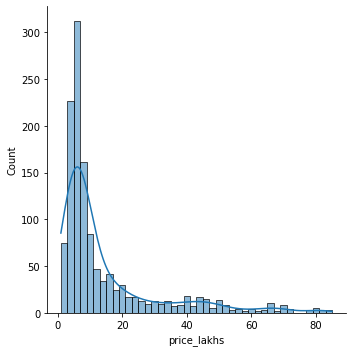

In [192]:
# x_upper = np.quantile(df['price(in lakhs)'], 0.99)

g = sns.displot(data=df
            , x='price_lakhs'
            , kind='hist', kde=True
#             , facet_kws={'xlim':(0,x_upper)}    
            )

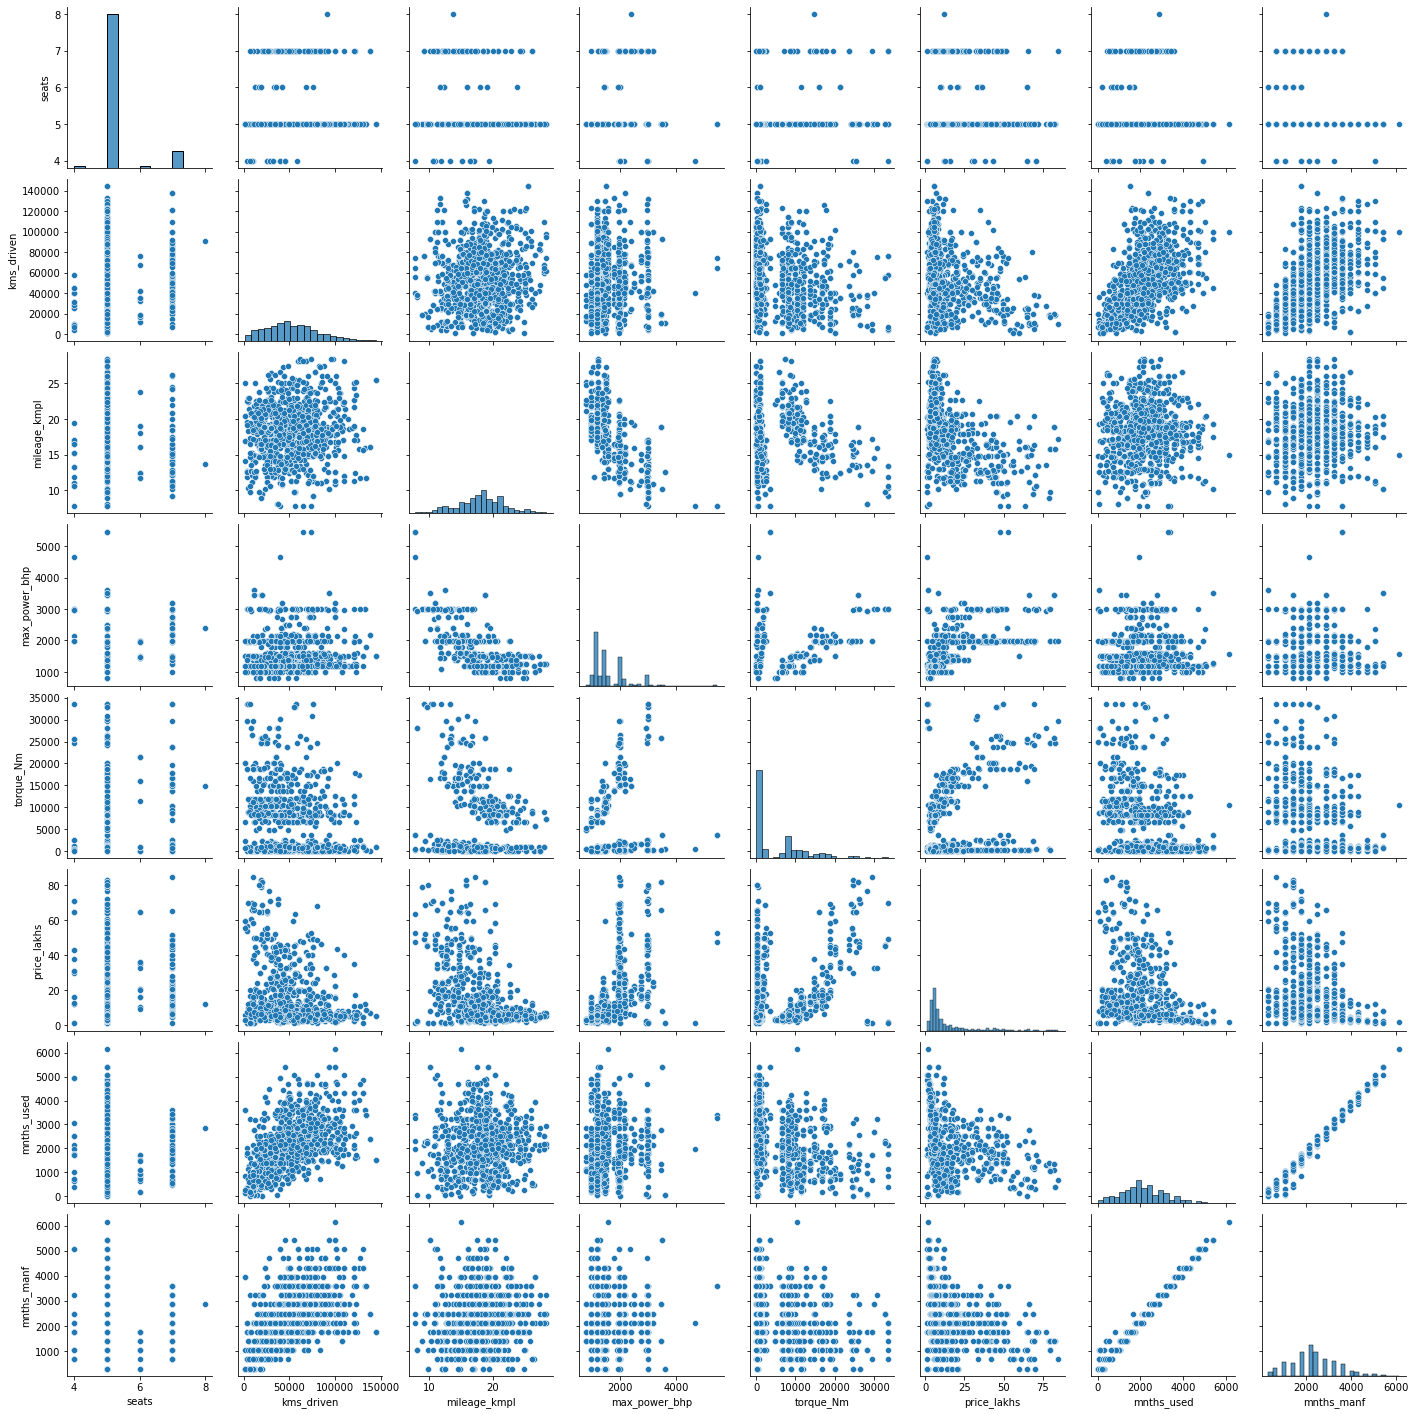

In [193]:
sns.pairplot(df)

In [214]:
df[df.torque_Nm <= 100]

,car_name,insurance_validity,fuel_type,seats,kms_driven,ownership,transmission,mileage_kmpl,max_power_bhp,torque_Nm,price_lakhs
21,2010 Maruti Swift 1.2 VXi BSII,Comprehensive,Petrol,5,100525,First Owner,Manual,16.10,1197.0,85.0,2.09
37,2022 Tata Tiago XZ Plus CNG BSVI,Comprehensive,CNG,5,30000,First Owner,Manual,26.49,1199.0,72.0,7.25
41,2010 Maruti Swift 1.2 VXi BSII,Comprehensive,Petrol,5,100525,First Owner,Manual,16.10,1197.0,85.0,2.09
57,2022 Tata Tiago XZ Plus CNG BSVI,Comprehensive,CNG,5,30000,First Owner,Manual,26.49,1199.0,72.0,7.25
69,2020 Renault KWID Climber 1.0 AMT Opt,Third Party insurance,Petrol,5,12503,First Owner,Automatic,22.00,999.0,67.0,5.15
...,...,...,...,...,...,...,...,...,...,...,...
1464,2017 Mahindra TUV 300 mHAWK100 T8,Comprehensive,Diesel,7,27236,Second Owner,Manual,18.49,1493.0,100.0,6.50
1473,2017 Mahindra Bolero mHAWK D70 ZLX,Third Party insurance,Diesel,7,37852,Second Owner,Manual,16.50,1493.0,70.0,6.75
1482,2014 Hyundai Grand i10 Sportz,Comprehensive,Petrol,5,22672,First Owner,Manual,18.90,1197.0,82.0,3.84
1524,2014 Hyundai Grand i10 AT Asta,Comprehensive,Petrol,5,22316,First Owner,Automatic,18.90,1197.0,82.0,4.54
